# Анализ кредитных дефолтов

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля для графиков
sns.set(style="whitegrid")

# Настройка шрифтов и языка для графиков
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## Загрузка данных

In [3]:
# Загрузка данных
data = pd.read_excel('/home/s/Code/jupyter/04/input_data/default_of_credit_card_clients.xls', header=1, engine='xlrd')

In [4]:
# Просмотр первых строк данных
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
# Информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [8]:
# Переименование столбцов на русский
data.columns = ['ID', 'Лимит_баланса', 'Пол', 'Образование', 'Семейное_положение', 'Возраст', 
                'Статус_платежа_сентябрь', 'Статус_платежа_август', 'Статус_платежа_июль', 
                'Статус_платежа_июнь', 'Статус_платежа_май', 'Статус_платежа_апрель', 
                'Сумма_счета_сентябрь', 'Сумма_счета_август', 'Сумма_счета_июль', 
                'Сумма_счета_июнь', 'Сумма_счета_май', 'Сумма_счета_апрель', 
                'Сумма_платежа_сентябрь', 'Сумма_платежа_август', 'Сумма_платежа_июль', 
                'Сумма_платежа_июнь', 'Сумма_платежа_май', 'Сумма_платежа_апрель', 
                'Дефолт_в_следующем_месяце']

## Предобработка данных

### Проверка наличия пропущенных значений

In [9]:
# Проверка наличия пропущенных значений
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

### Преобразование категориальных переменных

In [10]:
# Преобразование типов данных для оптимизации памяти
data['Лимит_баланса'] = data['Лимит_баланса'].astype(np.int32)
data['Возраст'] = data['Возраст'].astype(np.int8)
data[['Пол', 'Образование', 'Семейное_положение']] = data[['Пол', 'Образование', 'Семейное_положение']].astype('category')

### Оптимизация типов данных

In [11]:
data[['Статус_платежа_сентябрь', 'Статус_платежа_август', 'Статус_платежа_июль', 
      'Статус_платежа_июнь', 'Статус_платежа_май', 'Статус_платежа_апрель']] = data[['Статус_платежа_сентябрь', 'Статус_платежа_август', 'Статус_платежа_июль', 
                                                                                    'Статус_платежа_июнь', 'Статус_платежа_май', 'Статус_платежа_апрель']].astype(np.int8)
data[['Сумма_счета_сентябрь', 'Сумма_счета_август', 'Сумма_счета_июль', 
      'Сумма_счета_июнь', 'Сумма_счета_май', 'Сумма_счета_апрель']] = data[['Сумма_счета_сентябрь', 'Сумма_счета_август', 'Сумма_счета_июль', 
                                                                            'Сумма_счета_июнь', 'Сумма_счета_май', 'Сумма_счета_апрель']].astype(np.int32)
data[['Сумма_платежа_сентябрь', 'Сумма_платежа_август', 'Сумма_платежа_июль', 
      'Сумма_платежа_июнь', 'Сумма_платежа_май', 'Сумма_платежа_апрель']] = data[['Сумма_платежа_сентябрь', 'Сумма_платежа_август', 'Сумма_платежа_июль', 
                                                                                  'Сумма_платежа_июнь', 'Сумма_платежа_май', 'Сумма_платежа_апрель']].astype(np.int32)

### Преобразование категориальных переменных в числовые коды

In [12]:
# Исключаем столбец ID и целевую переменную
X = data.drop(columns=['ID', 'Дефолт_в_следующем_месяце'])
y = data['Дефолт_в_следующем_месяце']

# Преобразование категориальных переменных в числовые коды
X['Пол'] = X['Пол'].cat.codes
X['Образование'] = X['Образование'].cat.codes
X['Семейное_положение'] = X['Семейное_положение'].cat.codes

## Разделение данных

### Разделение данных на тренировочную и тестовую выборки

In [13]:
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение моделей

### Обучение моделей XGBoost и LightGBM

In [14]:
# Обучение моделей XGBoost и LightGBM
xgb_model = XGBClassifier()
lgb_model = LGBMClassifier()

xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5323, number of negative: 18677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221792 -> initscore=-1.255256
[LightGBM] [Info] Start training from score -1.255256


LGBMClassifier()

### Прогнозирование и оценка моделей

In [15]:
# Прогнозирование
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]

# Оценка моделей
xgb_auc = roc_auc_score(y_test, xgb_preds)
lgb_auc = roc_auc_score(y_test, lgb_preds)

print(f'AUC-ROC для XGBoost: {xgb_auc}')
print(f'AUC-ROC для LightGBM: {lgb_auc}')

AUC-ROC для XGBoost: 0.7705694040215266
AUC-ROC для LightGBM: 0.7814066097489598


### Прогнозирование будущих платежей

In [20]:
# Удаление столбца 'ID' из новых данных и проверка типов
new_data = new_data.drop(columns=['ID', 'Дефолт_в_следующем_месяце'], errors='ignore')

In [31]:
# Преобразование типов данных в новых данных с правильными именами столбцов
new_data['Лимит_баланса'] = new_data['Лимит_баланса'].astype(np.int32)
new_data['Возраст'] = new_data['Возраст'].astype(np.int8)
new_data[['Пол', 'Образование', 'Семейное_положение']] = new_data[['Пол', 'Образование', 'Семейное_положение']].astype('category')

In [32]:
# Прогнозирование с использованием модели XGBoost
future_preds_xgb = xgb_model.predict_proba(new_data)[:, 1]

In [34]:
# Проверка результатов
future_preds_xgb

array([0.80206287, 0.64216405, 0.08259652, ..., 0.83773816, 0.85321754,
       0.0924651 ], dtype=float32)

### Обучение моделей XGBoost и LightGBM

In [22]:
# Обучение моделей XGBoost и LightGBM
xgb_model = XGBClassifier()
lgb_model = LGBMClassifier()

xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5323, number of negative: 18677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221792 -> initscore=-1.255256
[LightGBM] [Info] Start training from score -1.255256


LGBMClassifier()

### Прогнозирование и оценка моделей

In [23]:
# Прогнозирование
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]

# Оценка моделей
xgb_auc = roc_auc_score(y_test, xgb_preds)
lgb_auc = roc_auc_score(y_test, lgb_preds)

print(f'AUC-ROC для XGBoost: {xgb_auc}')
print(f'AUC-ROC для LightGBM: {lgb_auc}')

AUC-ROC для XGBoost: 0.7705694040215266
AUC-ROC для LightGBM: 0.7814066097489598


## Визуализация результатов

### Визуализация важности признаков для XGBoost

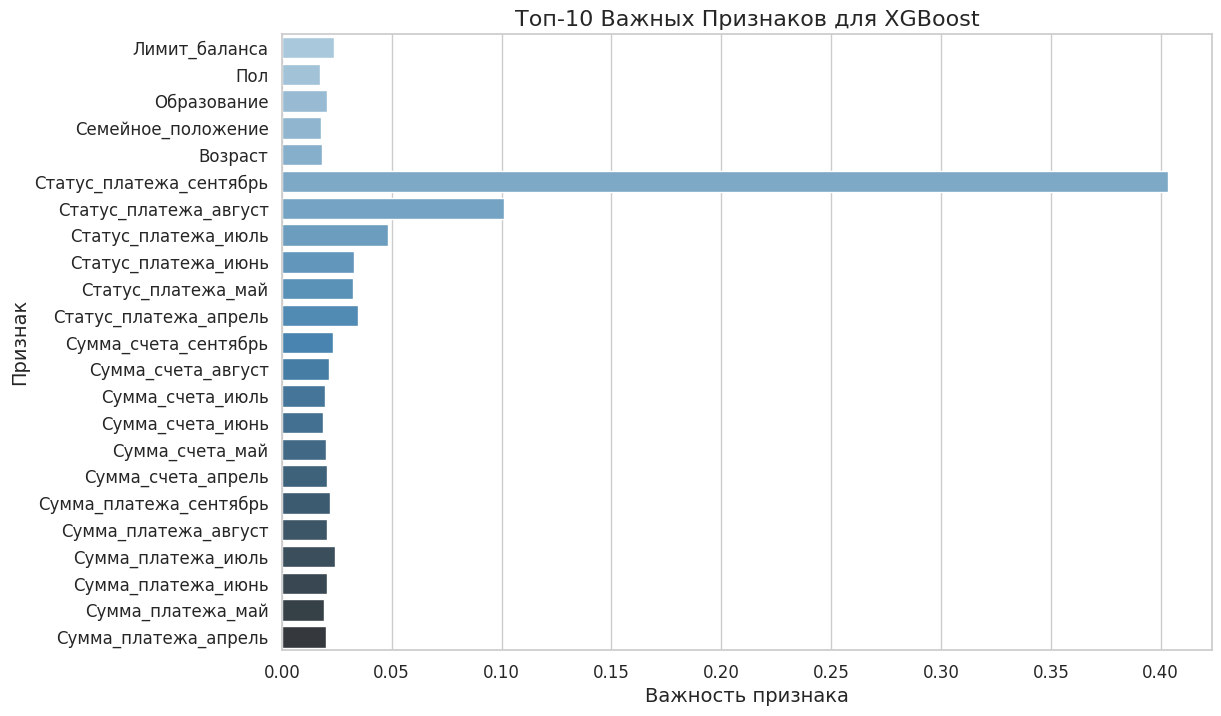

In [39]:
# Визуализация важности признаков для XGBoost
plt.figure(figsize=(12, 8))
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='Blues_d', hue='Feature', dodge=False, legend=False)
plt.xlabel('Важность признака', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.title('Топ-10 Важных Признаков для XGBoost', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Визуализация важности признаков для LightGBM

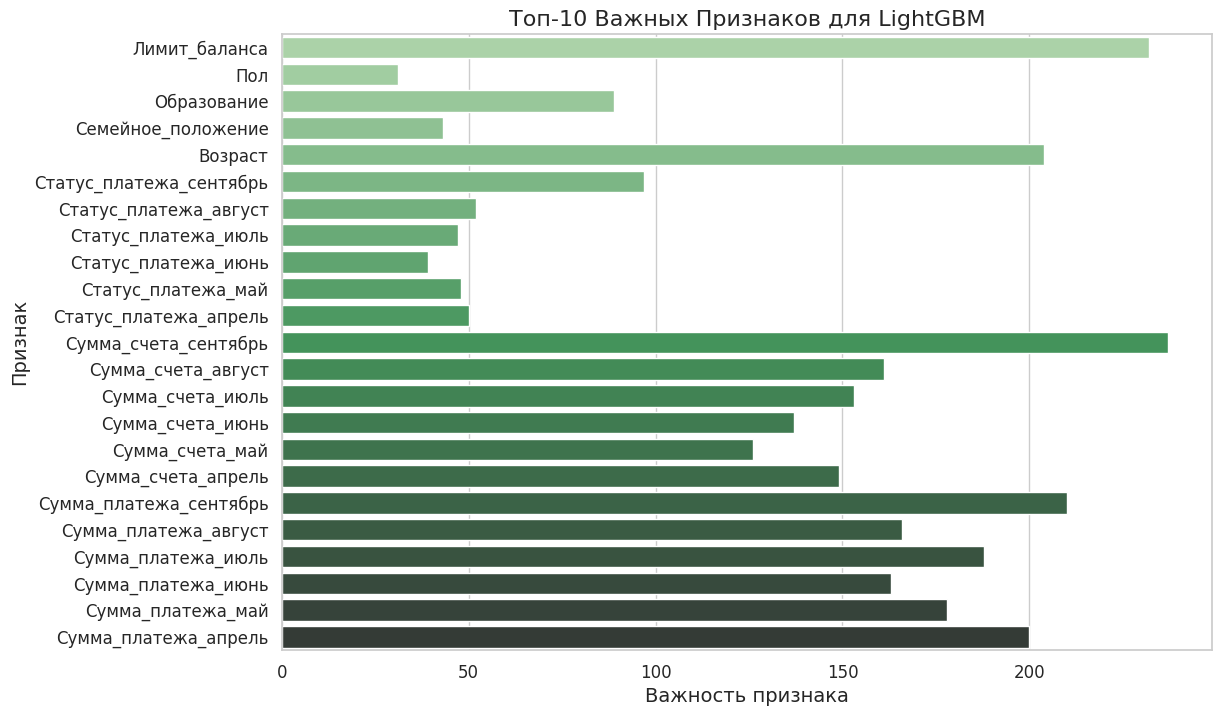

In [41]:
# Визуализация важности признаков для LightGBM
plt.figure(figsize=(12, 8))
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
})
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='Greens_d', hue='Feature', dodge=False, legend=False)
plt.xlabel('Важность признака', fontsize=14)
plt.ylabel('Признак', fontsize=14)
plt.title('Топ-10 Важных Признаков для LightGBM', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Факторы, влияющие на дефолт

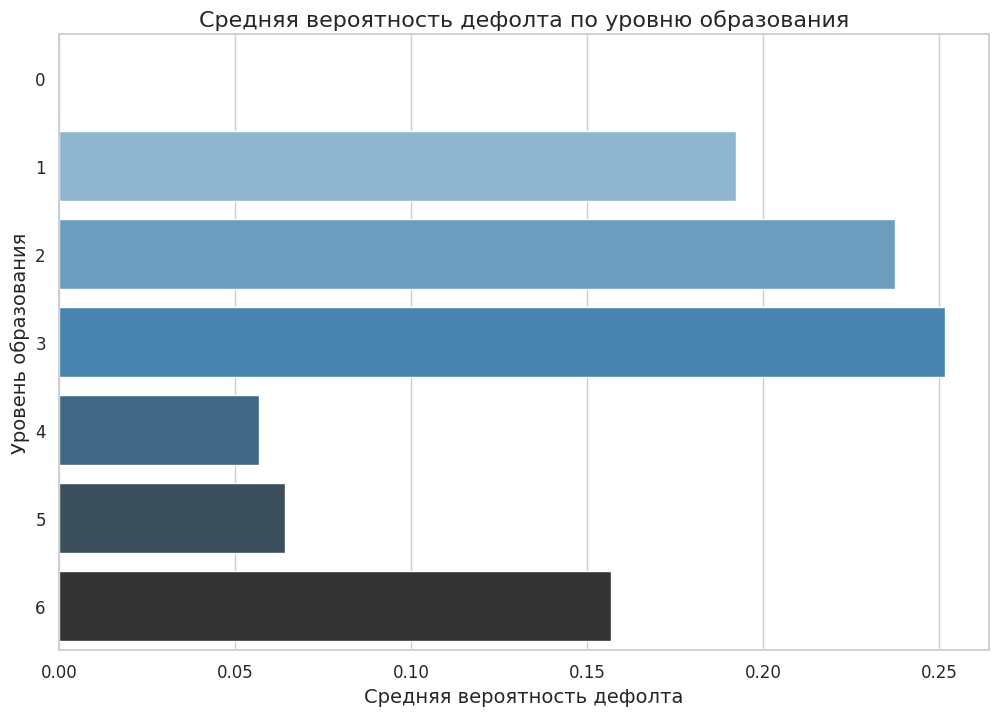

In [42]:
# Группировка данных по уровню образования и вычисление средней вероятности дефолта
factors = data.groupby('Образование', observed=True)['Дефолт_в_следующем_месяце'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=factors, x='Дефолт_в_следующем_месяце', y='Образование', palette='Blues_d', hue='Образование', dodge=False, legend=False, orient='h')
plt.ylabel('Уровень образования', fontsize=14)
plt.xlabel('Средняя вероятность дефолта', fontsize=14)
plt.title('Средняя вероятность дефолта по уровню образования', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Сегментация получателей

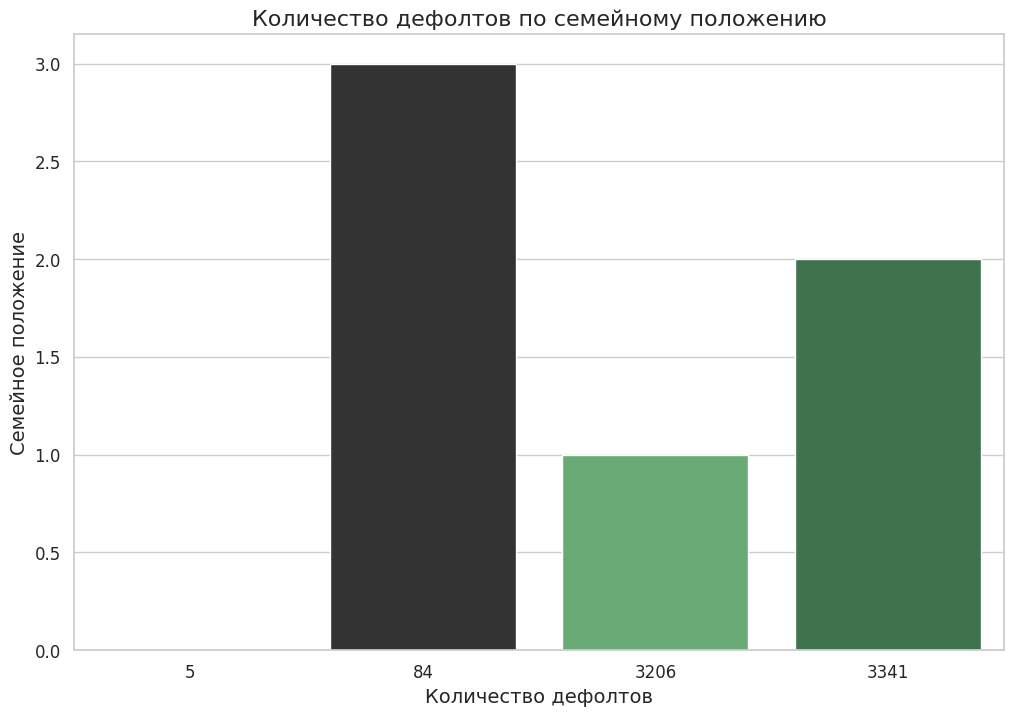

In [43]:
# Группировка данных по семейному положению и вычисление суммы дефолтов
segments = data.groupby('Семейное_положение', observed=True)['Дефолт_в_следующем_месяце'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=segments, x='Дефолт_в_следующем_месяце', y='Семейное_положение', palette='Greens_d', hue='Семейное_положение', dodge=False, legend=False)
plt.xlabel('Количество дефолтов', fontsize=14)
plt.ylabel('Семейное положение', fontsize=14)
plt.title('Количество дефолтов по семейному положению', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Тренды дефолтов по месяцам

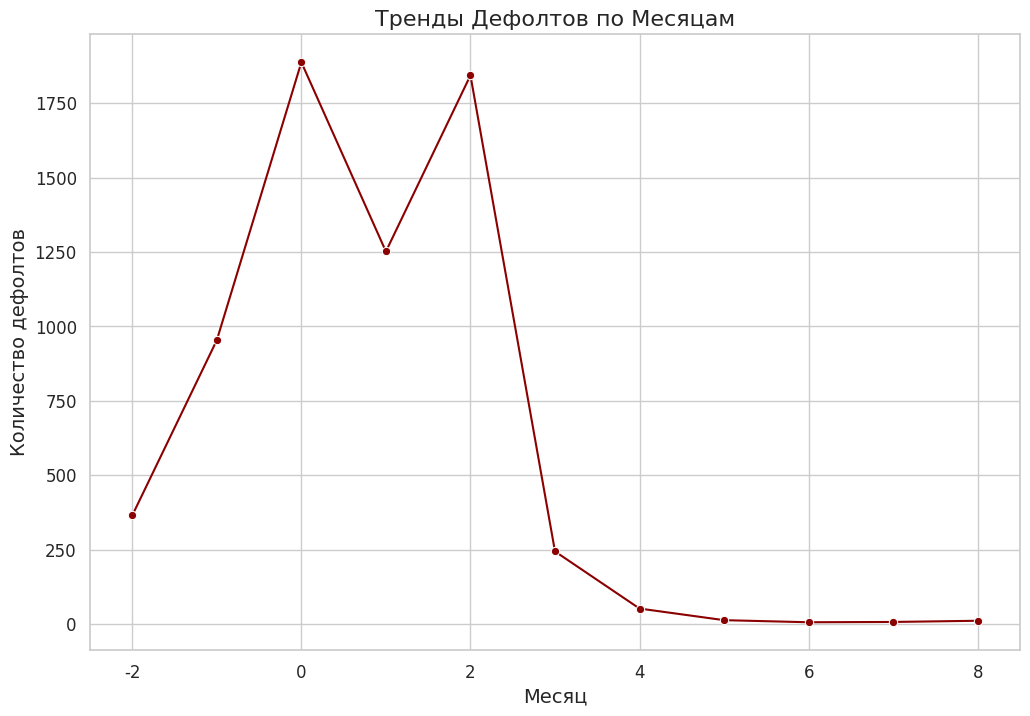

In [28]:
# Тренды дефолтов по месяцам
data['Месяц'] = data['Статус_платежа_сентябрь']
monthly_payments = data.groupby('Месяц')['Дефолт_в_следующем_месяце'].sum()
plt.figure(figsize=(12, 8))
sns.lineplot(x=monthly_payments.index, y=monthly_payments.values, marker='o', color='darkred')
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество дефолтов', fontsize=14)
plt.title('Тренды Дефолтов по Месяцам', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

## Закономерности в платежах

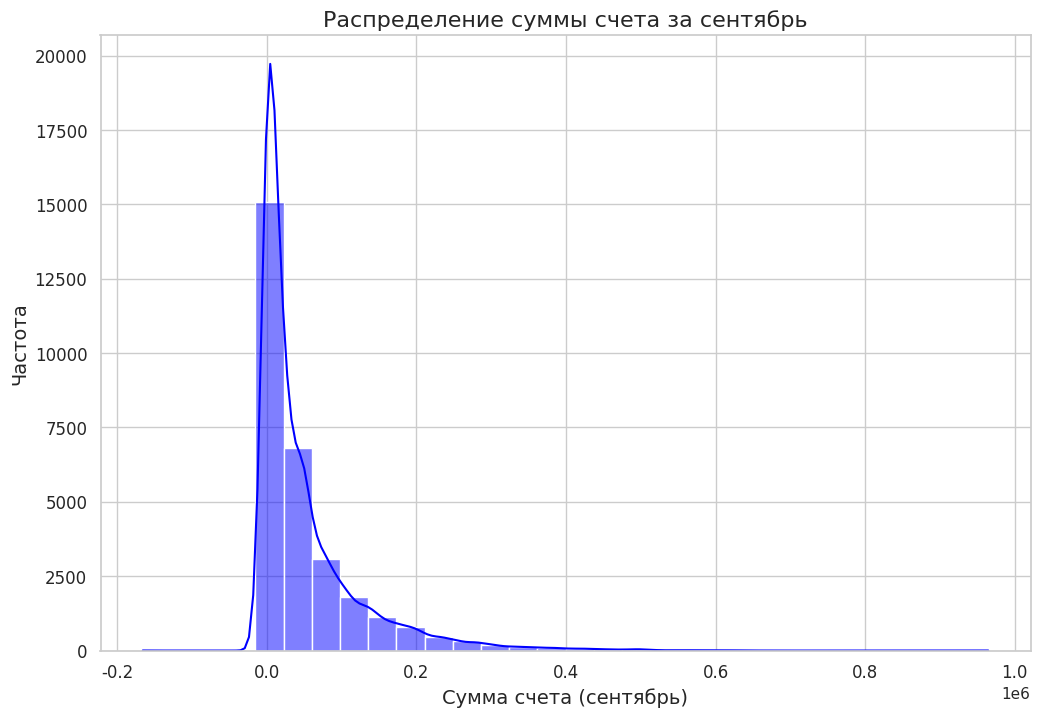

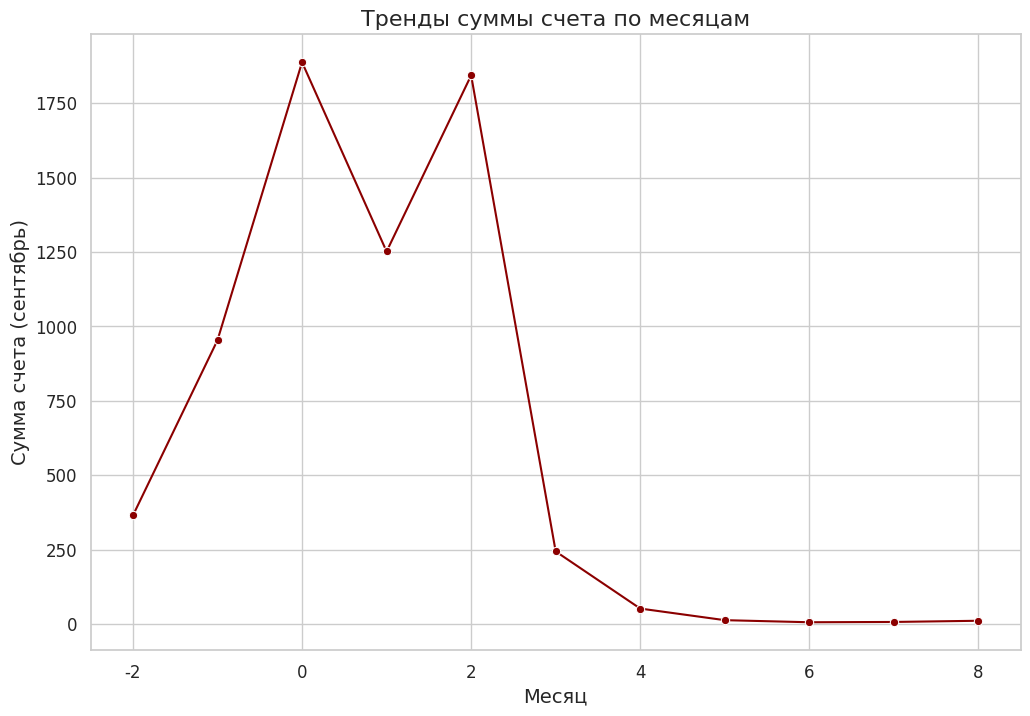

In [29]:
# Анализ закономерностей в платежах
plt.figure(figsize=(12, 8))
sns.histplot(data['Сумма_счета_сентябрь'], kde=True, color='blue', bins=30)
plt.xlabel('Сумма счета (сентябрь)', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.title('Распределение суммы счета за сентябрь', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(x=monthly_payments.index, y=monthly_payments.values, marker='o', color='darkred')
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Сумма счета (сентябрь)', fontsize=14)
plt.title('Тренды суммы счета по месяцам', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

## Анализ аномалий

### Выявление аномалий и подозрительных транзакций

In [30]:
# Выявление аномалий на основе нескольких признаков
important_features_list = ['Лимит_баланса', 'Сумма_счета_сентябрь', 'Сумма_платежа_сентябрь']

# Создаем DataFrame для аномалий
anomalies = pd.DataFrame()

for feature in important_features_list:
    feature_anomalies = data[data[feature] > data[feature].quantile(0.99)]
    anomalies = pd.concat([anomalies, feature_anomalies])

# Удаляем дубликаты
anomalies = anomalies.drop_duplicates()
anomalies.head()

,ID,Лимит_баланса,Пол,Образование,Семейное_положение,Возраст,Статус_платежа_сентябрь,Статус_платежа_август,Статус_платежа_июль,Статус_платежа_июнь,...,Сумма_счета_май,Сумма_счета_апрель,Сумма_платежа_сентябрь,Сумма_платежа_август,Сумма_платежа_июль,Сумма_платежа_июнь,Сумма_платежа_май,Сумма_платежа_апрель,Дефолт_в_следующем_месяце,Месяц
12,13,630000,1,2,2,41,-1,0,-1,-1,...,6500,2870,1000,6500,6500,6500,2870,0,0,-1
260,261,510000,1,1,2,29,0,0,0,0,...,87265,36739,40010,20094,5000,5001,25365,65000,0,0
433,434,580000,1,1,1,36,0,0,0,0,...,168755,167964,6422,6565,5951,6006,5894,5946,0,0
451,452,600000,0,1,1,53,2,2,0,0,...,440982,434715,0,18000,16000,16000,21000,20000,1,2
527,528,620000,1,2,1,45,2,2,0,0,...,167159,170894,0,6200,6000,6000,6500,6000,1,2
